In [153]:

import pandas as pd
import numpy as np
import os   



In [154]:
data_folder = "./data/"
clean_data = os.path.join(data_folder, "clean_data.csv")

In [155]:

data = pd.read_csv(clean_data, index_col=0 , header=[0, 1], parse_dates=True, dtype='float64')
data.head() 


Location                            Exit                  Input A            \
Custom Name         Sludge concentration Conductivity Temperature  Flowrate   
2022-01-17 17:10:00             0.264232     0.919453    0.653250  0.643428   
2022-01-17 17:15:00             0.266713     0.907712    0.654410  0.635926   
2022-01-17 17:20:00             0.269192     0.895971    0.655569  0.628423   
2022-01-17 17:25:00             0.271672     0.884230    0.656728  0.620921   
2022-01-17 17:30:00             0.274151     0.872489    0.657887  0.613419   

Location                                                               \
Custom Name         Amount of sludge Conductivity       TOC        pH   
2022-01-17 17:10:00        -0.745842    -0.572618 -0.452001 -0.475638   
2022-01-17 17:15:00        -0.743799    -0.573313 -0.457410 -0.686474   
2022-01-17 17:20:00        -0.741757    -0.574008 -0.462819 -0.358856   
2022-01-17 17:25:00        -0.739714    -0.574703 -0.468227 -0.351742   
2022-01-17 17:30:00        -0.737672    -0.575398 -0.473637 -0.315153   

Location                Input B            ...       Tank 1              \
Custom Name         Temperature  Flowrate  ... O2 dissolved Temperature   
2022-01-17 17:10:00   -0.623599 -0.105015  ...     0.348310    0.088772   
2022-01-17 17:15:00   -0.591382 -1.120546  ...     0.340932    0.089448   
2022-01-17 17:20:00   -0.591177  1.349922  ...     0.333555    0.090120   
2022-01-17 17:25:00   -0.652543 -0.000592  ...     0.326177    0.090793   
2022-01-17 17:30:00   -0.695602 -0.295467  ...     0.318800    0.091468   

Location               Tank 2                                              \
Custom Name           O2 perc pH regulator in flow Sludge recycle in flow   
2022-01-17 17:10:00 -0.464311            -0.073297               0.000668   
2022-01-17 17:15:00 -0.464108            -0.078491              -0.000206   
2022-01-17 17:20:00 -0.463910            -0.083686              -0.001074   
2022-01-17 17:25:00 -0.463707            -0.088880              -0.001941   
2022-01-17 17:30:00 -0.463505            -0.094074              -0.002809   

Location                                                               \
Custom Name         Air in flow Content height        pH O2 dissolved   
2022-01-17 17:10:00    0.067396      -0.581635 -0.367502     0.148147   
2022-01-17 17:15:00    0.065202      -0.581635 -0.366277     0.140298   
2022-01-17 17:20:00    0.063008      -0.581635 -0.365053     0.132448   
2022-01-17 17:25:00    0.060814      -0.581635 -0.363828     0.124603   
2022-01-17 17:30:00    0.053410      -0.581635 -0.362604     0.116753   

Location                         
Custom Name         Temperature  
2022-01-17 17:10:00    0.046031  
2022-01-17 17:15:00    0.046688  
2022-01-17 17:20:00    0.047345  
2022-01-17 17:25:00    0.048002  
2022-01-17 17:30:00    0.048656  

[5 rows x 31 columns]

In [156]:
# Extracting the target Mean and std from the unnormalized data

unnormalized_clean_data_path = os.path.join(data_folder, "unnormalized_clean_data.csv")
unnormalized_clean_data = pd.read_csv(unnormalized_clean_data_path, index_col=0 , header=[0, 1], parse_dates=True, dtype='float64')

target_mean = unnormalized_clean_data.loc[:, ('Exit', 'Target')].mean()
target_std = unnormalized_clean_data.loc[:, ('Exit', 'Target')].std()


In [157]:
from sklearn.model_selection import train_test_split


X = data.drop(('Exit', 'Target'), axis=1)
y = data[('Exit', 'Target')]
# Split the data into training and temporary sets
train_data, X_temp, target_train_data, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
validation_data, testing_data, target_validation_data, target_testing_data = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# train_data, target_train_data , validation_data, target_validation_data , target_testing_data 


# Feature Engineering

We will now apply some transformations and clever tricks to our dataset to make it "more suitable" for the training procedure.
The first transformation is principal component analysis on the `Tank 1` and `Tank 2` data

## Principal Component Analysis for Tank 1 and Tank 2

As the plot of the following code cell shows, the 14 (7 x 2) variables can be reduced to just 10 variable, and 98.56 % of the variance can still be explained.

We will go for 10 principal components. Essentially, we reduced our 14 variables to just 10 variables, without a significant loss in information.

array([0.24341435, 0.46681978, 0.61502947, 0.71660355, 0.79003653,
       0.85737759, 0.90502433, 0.93505025, 0.95615741, 0.97630429,
       0.98691863, 0.99662613, 0.99844611, 0.99930212, 0.99990841,
       1.        ])

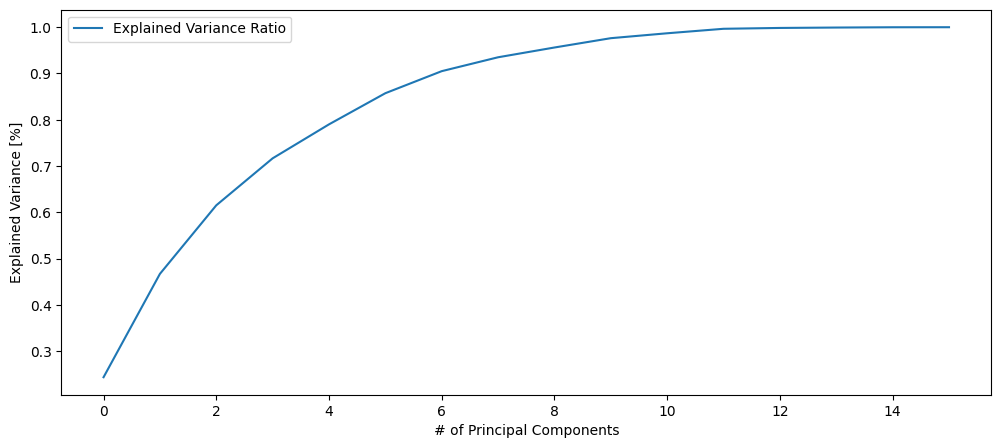

In [158]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

selection = train_data.loc[:, (['Tank 1', 'Tank 2'], slice(None))].copy()
pca = PCA()
pca.fit(selection)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(pca.explained_variance_ratio_.cumsum(),
        label="Explained Variance Ratio")
ax.set_xlabel('# of Principal Components')
ax.set_ylabel('Explained Variance [%]')
ax.legend()
pca.explained_variance_ratio_.cumsum()

In [159]:
n_pca_components = 10

pca = PCA(n_components=n_pca_components)
pca.fit(selection)

PCA(n_components=10)

In [160]:
train_tank_pca = pd.DataFrame(pca.transform(train_data[selection.columns]),
                               index=train_data.index,
                               columns=[f'PC {i}' for i in range(n_pca_components)])
val_tank_pca = pd.DataFrame(pca.transform(validation_data[selection.columns]),
                               index=validation_data.index,
                               columns=[f'PC {i}' for i in range(n_pca_components)])

In [161]:
train_tank_pca.head()

,PC 0,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,PC 7,PC 8,PC 9
2022-07-08 06:20:00,2.872990,1.355624,1.038978,-1.824539,0.097728,0.586717,-0.343722,-0.813254,0.588701,0.420106
2022-04-27 20:00:00,-1.614261,0.647520,-1.596552,-0.399599,0.854128,0.417280,-0.643608,0.936703,0.071209,-0.120584
2022-07-20 04:50:00,3.909827,1.799102,0.613409,-0.997539,0.577046,-0.587994,-0.087941,-0.164608,-1.018734,0.174332
2022-06-04 12:35:00,0.344652,-0.290143,-0.762993,0.426060,-0.382905,-0.783420,0.272910,-0.839070,-0.129363,-0.578289
2022-06-03 13:35:00,-0.150033,0.542268,-0.609338,-2.202626,-1.214421,-1.594318,0.716065,-2.027653,0.185348,0.148989


The following grouper variable will allow us to group periods of time without gaps longer than 5 minutes (300 seconds) together. This will be relevant when we provide a history of timestamps at the input of a model. In such case, the the input will assume that the timestamps are spaced 5 minutes from each other. 

In [162]:
grouper = (data.index.to_frame().diff()[0].apply(lambda v: v.seconds) > 300).cumsum()

## Merging the Engineerd Features with the other ones

The Tank1 and Tank2 data (14 variables) are replaced by the PCA features (10 variables).

In [163]:
# Set MultiIndex for PCA columns
train_tank_pca.columns = pd.MultiIndex.from_product([['Tanks',], train_tank_pca.columns])
val_tank_pca.columns = pd.MultiIndex.from_product([['Tanks', ], val_tank_pca.columns])

In [164]:
target_train_data.head()

2022-07-08 06:20:00   -0.673507
2022-04-27 20:00:00    0.047718
2022-07-20 04:50:00   -0.640603
2022-06-04 12:35:00   -0.085202
2022-06-03 13:35:00   -0.629545
Name: (Exit, Target), dtype: float64

In [165]:
tr_no_tank_col_mask = ~(train_data.columns.get_level_values(0).isin(['Tank 1', 'Tank 2']))
val_no_tank_col_mask = ~(validation_data.columns.get_level_values(0).isin(['Tank 1', 'Tank 2']))

train_features = pd.concat([train_tank_pca, train_data[train_data.columns[tr_no_tank_col_mask]], target_train_data], axis=1)
val_features = pd.concat([val_tank_pca, validation_data[validation_data.columns[val_no_tank_col_mask]], target_validation_data], axis=1)

# Shifting the target in order to predict into the future

In [166]:
prediction_horizon = 10 # Hours

Shift the target 5 hours back in time, only retain the timestamps that are common between the shifted target and the original input

In [167]:
tr_shift_idx = train_features.index - pd.Timedelta(prediction_horizon, 'hour')
val_shift_idx = val_features.index - pd.Timedelta(prediction_horizon, 'hour')

# train_features.loc[:, ('Exit', 'Target')] = data.loc[:, ('Exit', 'Target')]

tr_shift_target = pd.Series(data=train_features.loc[:, ('Exit', 'Target')].values, 
                            index=tr_shift_idx, 
                            name='Target')
val_shift_target = pd.Series(data=val_features.loc[:, ('Exit', 'Target')].values, 
                             index=val_shift_idx, 
                             name='Target')

common_tr_idxs = tr_shift_idx.intersection(train_features.index)
common_val_idxs = val_shift_idx.intersection(val_features.index)

In [168]:
train_target = tr_shift_target.loc[common_tr_idxs]
val_target = val_shift_target.loc[common_val_idxs]

train_target_unnorm = train_target * target_std + target_mean
val_target_unnorm = val_target * target_std + target_mean

train_features = train_features.loc[common_tr_idxs]
val_features = val_features.loc[common_val_idxs]

## Functions for model evaluation

In [169]:
def show_model_results(mod_train_pred, mod_val_pred, model_name, y_true_train=None, y_true_val=None):
    if y_true_train is None:
        y_true_train = train_target_unnorm
    if y_true_val is None:
        y_true_val = val_target_unnorm
        
    results = pd.DataFrame(index=[model_name, ],
                           columns=['Training MAE', 'Training MSE', 
                                    'Validation MAE', 'Validation MSE'])
    results['Training MAE'] = np.mean(np.abs(y_true_train - mod_train_pred))
    results['Training MSE'] = np.mean(np.square(y_true_train - mod_train_pred))
    results['Validation MAE'] = np.mean(np.abs(y_true_val - mod_val_pred))
    results['Validation MSE'] = np.mean(np.square(y_true_val - mod_val_pred))
    display(results)
    
    train_size = y_true_train.shape[0]
    val_size = y_true_val.shape[0]
    
    fig, ax = plt.subplots(figsize=(17, 5))
    ax.plot(range(train_size), mod_train_pred, alpha=.75,  color='C1', label='Training Prediction')
    ax.plot(range(train_size), y_true_train, linestyle='--', color='C0', alpha=.75, label='Training Exact')

    ax.plot(range(train_size, train_size+val_size),
            mod_val_pred, color='C3', alpha=.75, label='Validation Prediction')
    ax.plot(range(train_size, train_size+val_size), y_true_val, linestyle='--', alpha=.75, color='C2', label='Validation Exact')
    ax.legend()

    ax.set_title('Prediction vs Exact - Training and Validation')
    
    return fig, ax, results

def analyze_residuals(mod_train_pred, mod_val_pred, y_true_train=None, y_true_val=None):
    if y_true_train is None:
        y_true_train = train_target_unnorm
    if y_true_val is None:
        y_true_val = val_target_unnorm
        
    fig, ax = plt.subplots(2, 2, figsize=(17, 7), gridspec_kw={'width_ratios': [2, 1]})

    train_res = (y_true_train - mod_train_pred)
    val_res = (y_true_val - mod_val_pred)

    rel_train_res = train_res / y_true_train
    rel_val_res = val_res / y_true_val
        
    train_size = y_true_train.shape[0]
    val_size = y_true_val.shape[0]
    
    ax[0, 0].plot(range(train_size), train_res, color='C0', label='Training Error')
    ax[0, 0].plot(range(train_size, train_size+val_size),val_res, color='C1', label='Validation Error')
    ax[0, 0].legend()
    ax[0, 0].set_title('Training and validation error')

    ax[1, 0].plot(range(train_size), rel_train_res, 
                  color='C0', label='Relative Training Error')
    ax[1, 0].plot(range(train_size, train_size+val_size), rel_val_res,
                  color='C1', label='Relative Validation Error')
    ax[1, 0].legend()
    ax[1, 0].set_title('Relative Training and validation error')

    ax[0, 1].hist(train_res, bins=100, color='C0', label='Training')
    ax[0, 1].axvline(train_res.mean(), linestyle='--', color='C1', label='Average')
    ax[0, 1].legend()
    ax[0, 1].set_title('Training: %.2f mean | %.2f std' % (train_res.mean(), train_res.std()))

    ax[1, 1].axvline(val_res.mean(), linestyle='--', color='C1', label='Average')
    ax[1, 1].hist(val_res, bins=100, color='C0', label='Validation Errors')
    ax[1, 1].legend()
    ax[1, 1].set_title('Validation: %.2f mean | %.2f std' % (val_res.mean(), val_res.std()))
    
    fig.tight_layout()
    return fig, ax

def unnormalize_target(norm_target):
    return norm_target * target_std + target_mean

The following code block keeps track of the results that we have obtained

In [170]:
model_results = []

# Baseline model

For the baseline model we take the most simple thing possible: the prediction of the contamination in 5 hours is simply the current amount of contamination at the exit.

This baseline model will probably not work very well at all. The goal of the models that follow in this notebook is to beat this baseline model.

In [171]:
tr_baseline_pred = train_features.loc[:, ('Exit', 'Target')] * target_std + target_mean
val_baseline_pred = val_features.loc[:, ('Exit', 'Target')] * target_std + target_mean

,Training MAE,Training MSE,Validation MAE,Validation MSE
Baseline Model,0.435285,0.968534,0.381549,0.757391


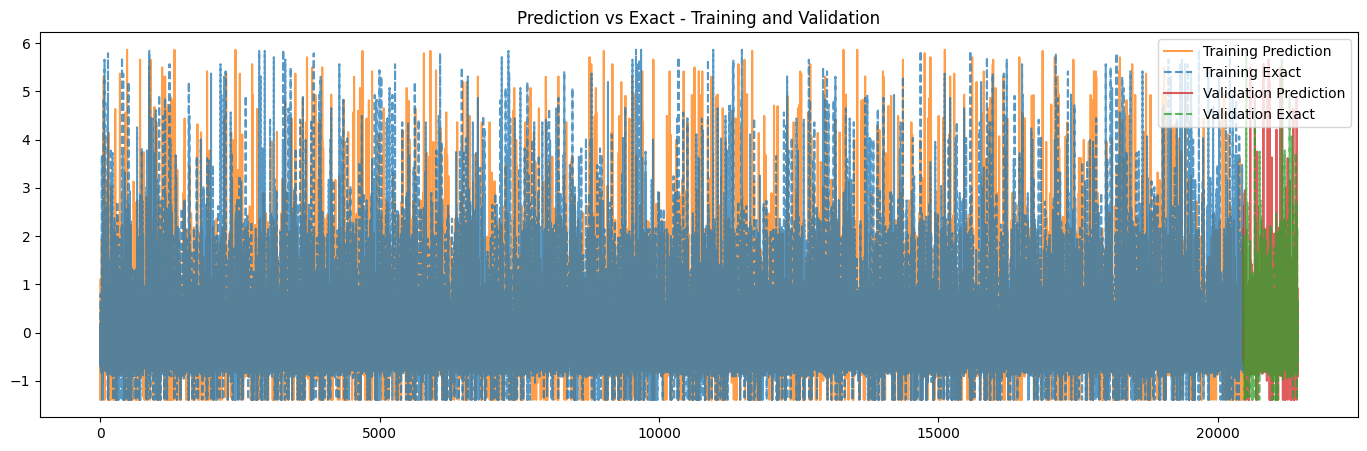

In [172]:
fig, ax, result = show_model_results(tr_baseline_pred, val_baseline_pred, 'Baseline Model')
model_results.append(result)

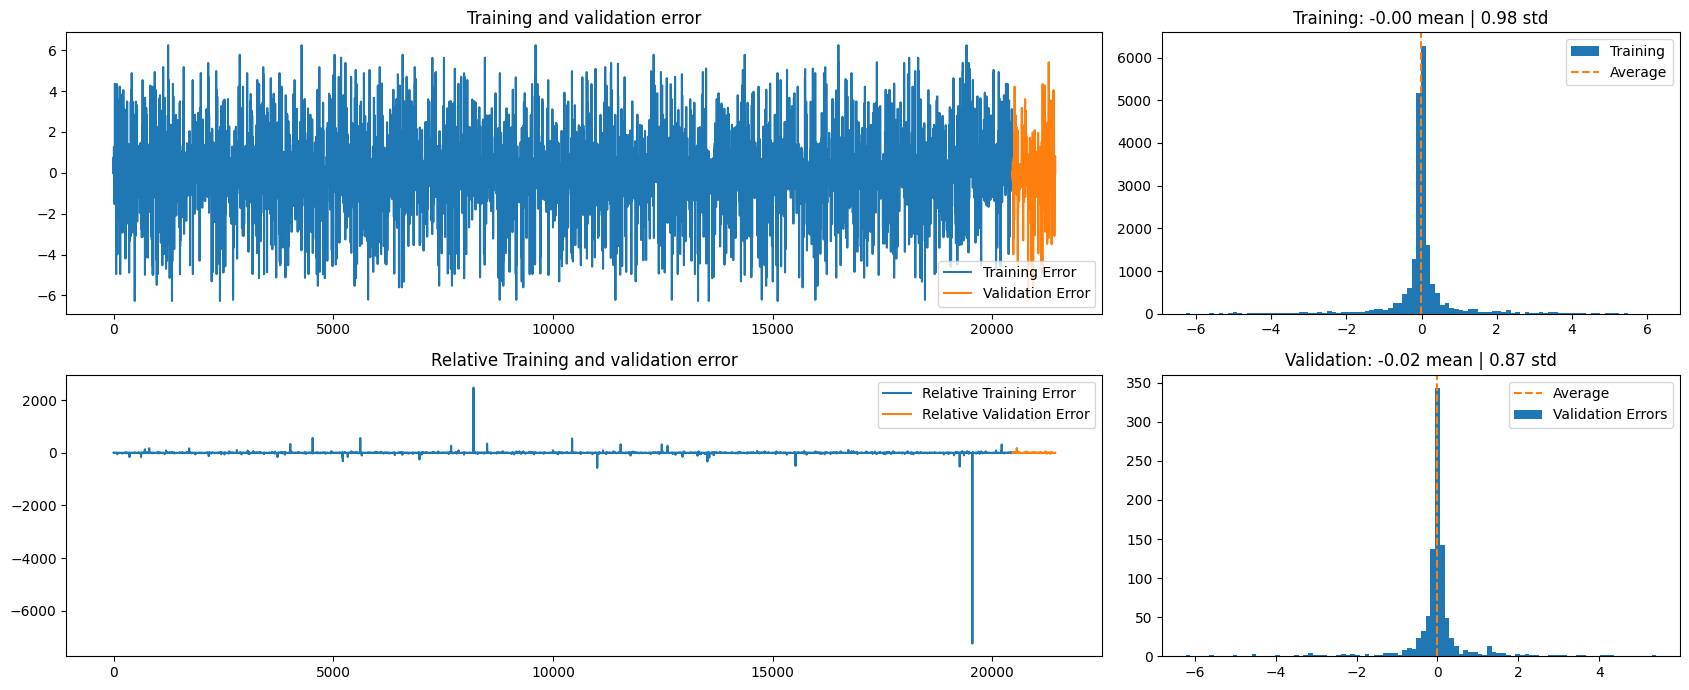

In [173]:
fig, ax = analyze_residuals(tr_baseline_pred, val_baseline_pred)

# Linear model
The first model that we try is a linear model, which we will use as a baseline. We will try to beat this baseline with other more nonlinear models.

In [174]:
from sklearn import linear_model

Model Training

In [175]:
lin_mod = linear_model.LinearRegression()
lin_mod = lin_mod.fit(train_features, train_target)

Model Evaluation

In [176]:
train_pred = unnormalize_target(lin_mod.predict(train_features))
val_pred = unnormalize_target(lin_mod.predict(val_features))

,Training MAE,Training MSE,Validation MAE,Validation MSE
Linear Model,0.457585,0.632699,0.41268,0.457542


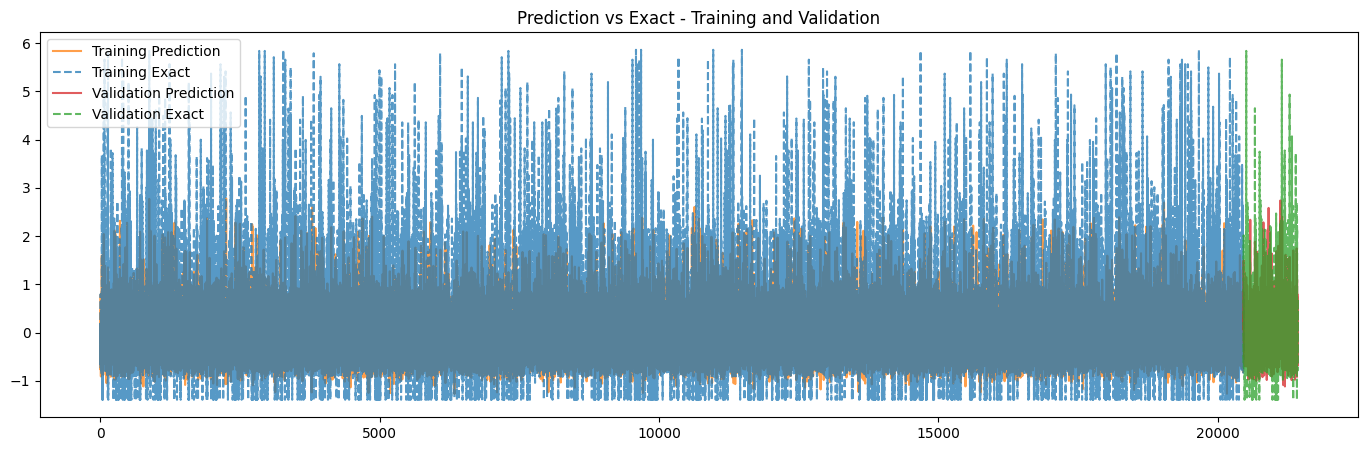

In [177]:
fig, ax, result = show_model_results(train_pred, val_pred, 'Linear Model');
model_results.append(result)

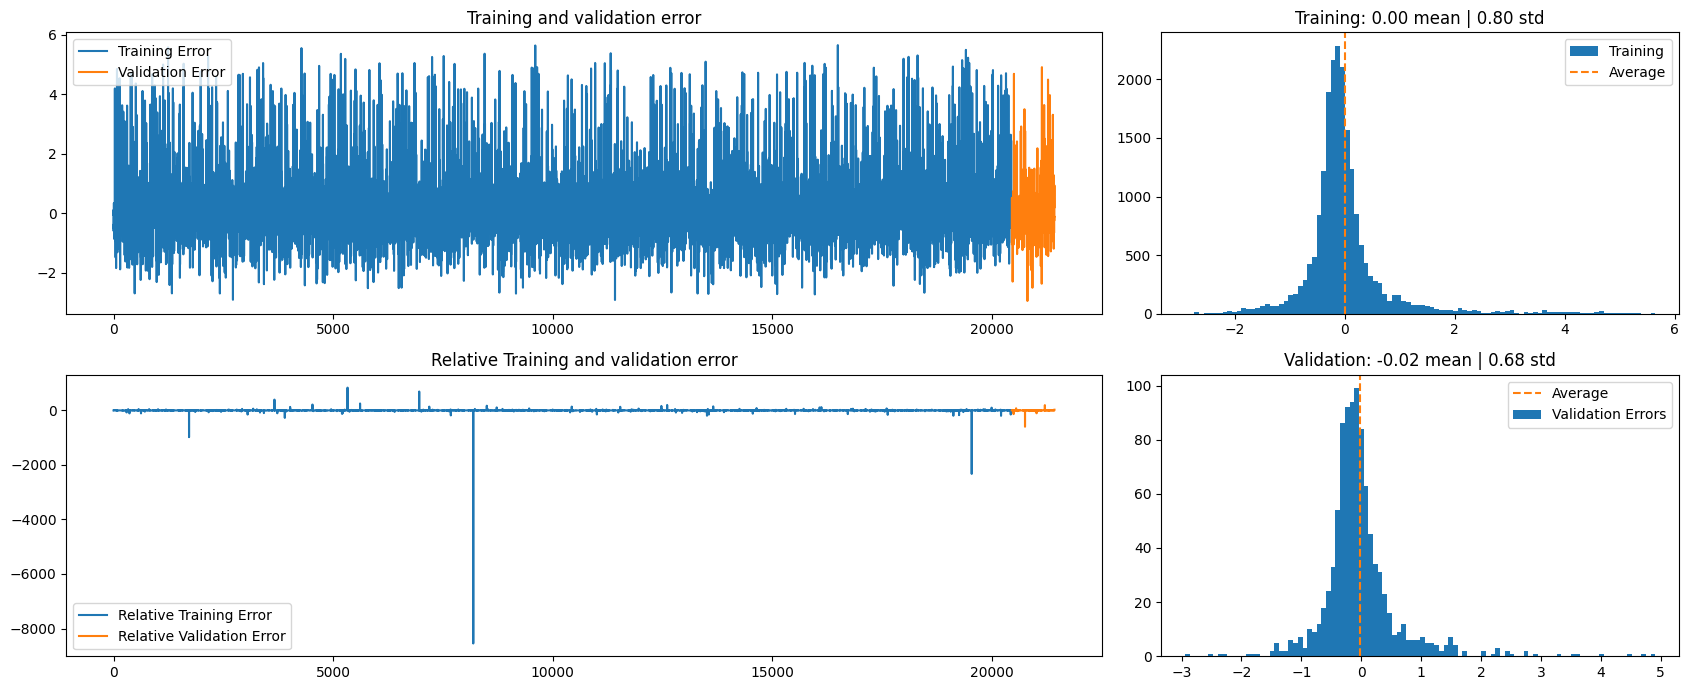

In [178]:
fig, ax = analyze_residuals(train_pred, val_pred)

# Gradient boosting regressor

The following code blocks try out a gradient boosting regressor. A grid serach over a subset of the hyperparameter space is performed in order to find suiteable hyperparameters. 

The grid search is relatively small, with $2^3$ parameters. Choosing a larger grid space might lead to better results, but will take longer to train.

The grid search uses 5-fold cross validation on the training set in order to get a validation performance metric.

In [179]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [180]:
params = { 'max_depth': [3,10],
           'learning_rate': [0.01, 0.1],
           'n_estimators': [50, 150]}

xgbr = xgb.XGBRegressor(seed = 20)

grid_search = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
grid_search.fit(train_features, train_target)

xgb_regressor = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [181]:
train_pred = unnormalize_target(xgb_regressor.predict(train_features))
val_pred = unnormalize_target(xgb_regressor.predict(val_features))

,Training MAE,Training MSE,Validation MAE,Validation MSE
Gradient Boosting Model,0.020907,0.001167,0.057374,0.021928


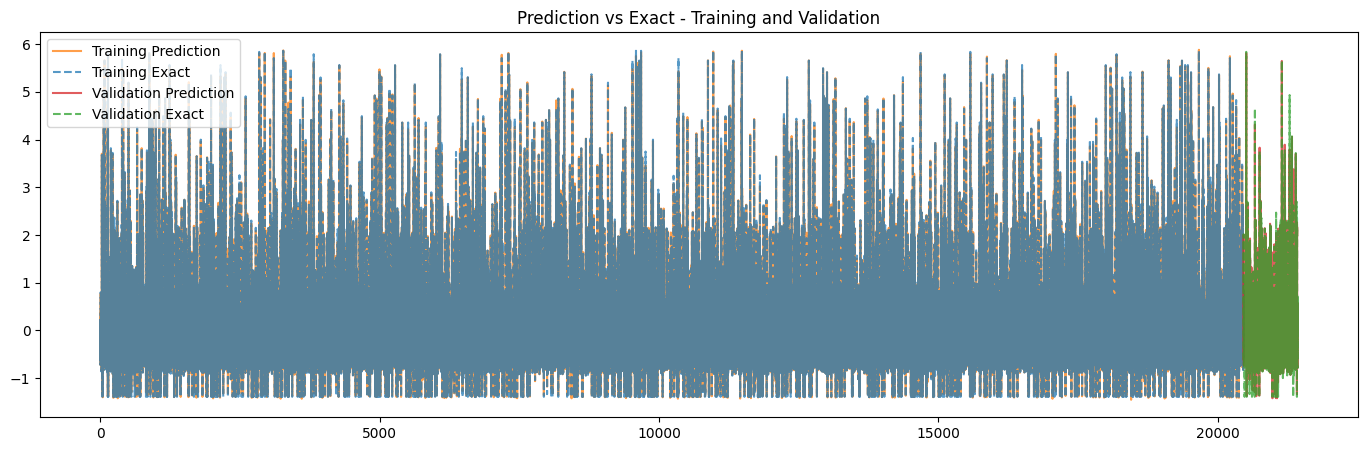

In [182]:
fig, ax, result = show_model_results(train_pred, val_pred, 'Gradient Boosting Model')
model_results.append(result)

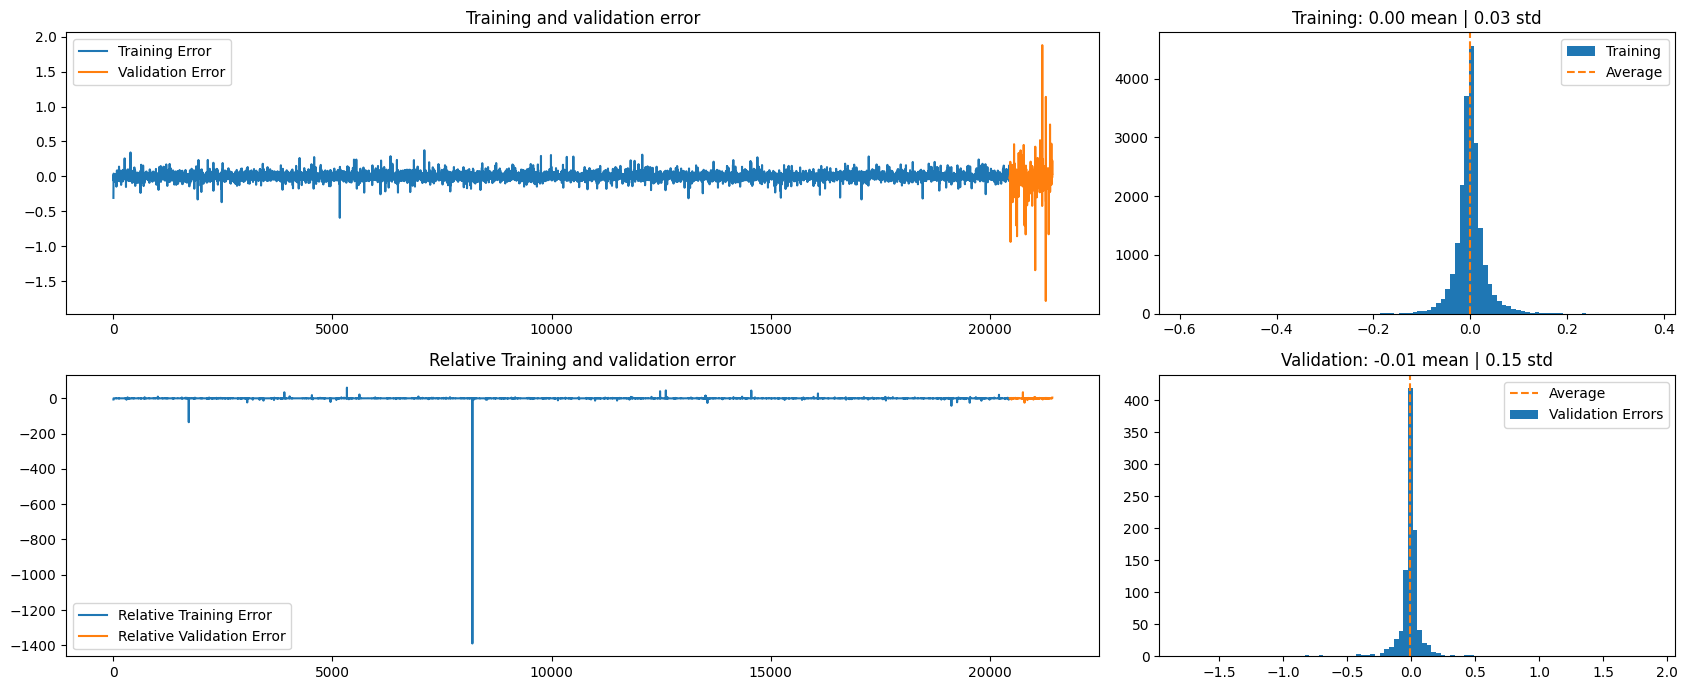

In [183]:
fig, ax = analyze_residuals(train_pred, val_pred)

# Neural Networks
## (Simple) Feed-Forward Neural Network

We now try a simple feed forward neural network. The network consists of three fully connected layers
* The first layer has 16 units and a ReLU activation function
* The second layer has 8 units and a ReLU activation function
* The third layer had 4 units and a ReLU activation function

The output layer has 1 unit, because we are trying to predict one value, which is the contamination of the water 5 hours in the future.

In [184]:
import tensorflow as tf

In [185]:
BATCH_SIZE = 64
n_epochs = 15

In [186]:
def basic_model():
    inp = tf.keras.Input(shape=(train_features.shape[1]))
    dense = tf.keras.layers.Dense(16, activation='relu')(inp)
    dense = tf.keras.layers.Dense(8, activation='relu')(dense)
    dense = tf.keras.layers.Dense(4, activation='relu')(dense)
    out = tf.keras.layers.Dense(1)(dense)
    
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                loss=tf.keras.losses.mean_absolute_error,
                metrics=['mse', 'mae'])
    return model

The following code block creates a TensorFlow Dataset object, which we will pass on to the `fit` function of the neural network. A TensorFlow Dataset is an efficient way to pass data to a model for training or inference. 

In [187]:
train_tf_x = tf.data.Dataset.from_tensor_slices(train_features)
train_tf_y = tf.data.Dataset.from_tensor_slices(train_target)
training_set = tf.data.Dataset.zip((train_tf_x, train_tf_y))
training_set = training_set.batch(BATCH_SIZE)

val_tf_x = tf.data.Dataset.from_tensor_slices(val_features)
val_tf_y = tf.data.Dataset.from_tensor_slices(val_target)
validation_set = tf.data.Dataset.zip((val_tf_x, val_tf_y))
validation_set = validation_set.batch(BATCH_SIZE)

In [188]:
simple_tf_model = basic_model()
simple_tf_model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_24 (Dense)            (None, 16)                416       
                                                                 
 dense_25 (Dense)            (None, 8)                 136       
                                                                 
 dense_26 (Dense)            (None, 4)                 36        
                                                                 
 dense_27 (Dense)            (None, 1)                 5         
                                                                 
Total params: 593 (2.32 KB)
Trainable params: 593 (2.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The following code block summarizes the shape of our neural network, together with the intermediate shapes of the layers and the number of parameters in each layer.

The model that we have defined here is relatively small (641 trainable parameters), becuase our dataset at hand is not super large. 

In [189]:
simple_tf_model.fit(training_set.shuffle(BATCH_SIZE), 
                    validation_data=validation_set, 
                    epochs=n_epochs)

Epoch 1/15
320/320 [==============================] - 0s 600us/step - loss: 0.4821 - mse: 0.7335 - mae: 0.4821 - val_loss: 0.3161 - val_mse: 0.4143 - val_mae: 0.3161
Epoch 2/15
320/320 [==============================] - 0s 596us/step - loss: 0.3535 - mse: 0.6106 - mae: 0.3535 - val_loss: 0.2834 - val_mse: 0.3815 - val_mae: 0.2834
Epoch 3/15
320/320 [==============================] - 0s 462us/step - loss: 0.3314 - mse: 0.5881 - mae: 0.3314 - val_loss: 0.2706 - val_mse: 0.3651 - val_mae: 0.2706
Epoch 4/15
320/320 [==============================] - 0s 475us/step - loss: 0.3209 - mse: 0.5768 - mae: 0.3209 - val_loss: 0.2616 - val_mse: 0.3626 - val_mae: 0.2616
Epoch 5/15
320/320 [==============================] - 0s 448us/step - loss: 0.3128 - mse: 0.5676 - mae: 0.3128 - val_loss: 0.2563 - val_mse: 0.3561 - val_mae: 0.2563
Epoch 6/15
320/320 [==============================] - 0s 439us/step - loss: 0.3065 - mse: 0.5603 - mae: 0.3065 - val_loss: 0.2531 - val_mse: 0.3548 - val_mae: 0.2531
Epoc

In [190]:
train_pred = unnormalize_target(simple_tf_model.predict(training_set))
train_pred = train_pred[:, 0]
val_pred = unnormalize_target(simple_tf_model.predict(validation_set))
val_pred = val_pred[:, 0]

  1/320 [..............................] - ETA: 9s

16/16 [==============================] - 0s 342us/step


,Training MAE,Training MSE,Validation MAE,Validation MSE
Feed Forward NN,0.280616,0.517655,0.236435,0.330016


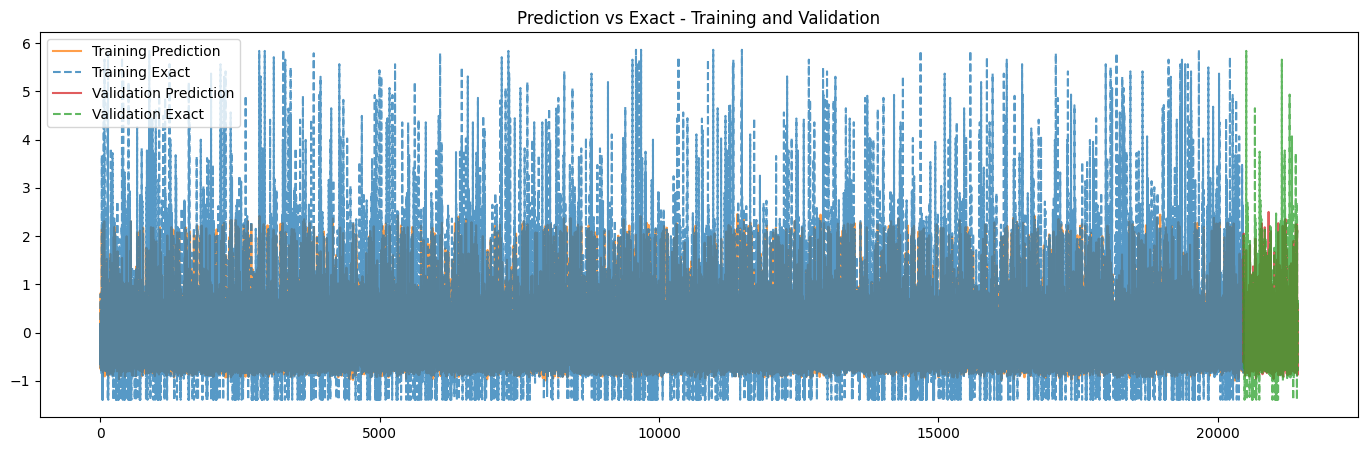

In [191]:
fig, ax, results = show_model_results(train_pred, val_pred, 'Feed Forward NN')
model_results.append(results)

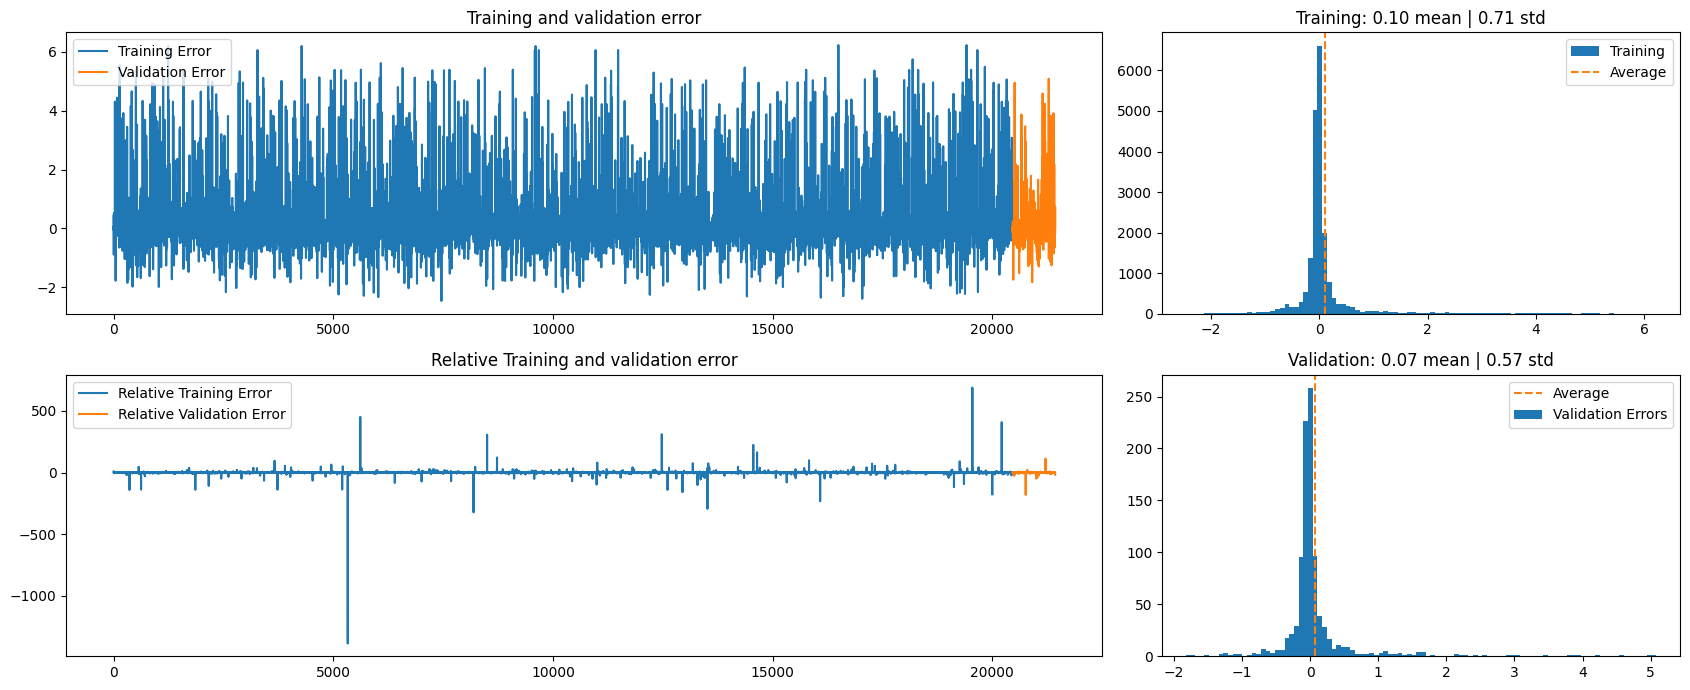

In [192]:
fig, ax = analyze_residuals(train_pred, val_pred)

## LSTM Neural Network

We now try a Long-Short Term Neural network. These networks are highly suited for time-series data, because the LSTM cells are equiped with an internal state. This internal state can act as something lke a memory, which makes the network able to see both long-term and short-term relations in the data. 

One of the disadvantages of LSTM networks are the difficulty to train them. The LSTM network that we train here will take 24 timestamps of each variable at its input. When we decrease this input horizon, the network will quickly converge towards a constant output of approximately 0 (which is not what we want).

In [193]:
import tensorflow as tf
import tensorflow.keras.layers as layers

### Defining the Model Architecture and Compilation

The architecture of the LSTM model is almost the same as the feed forward neural network that we used earlier, the only difference is that the first dense layer (which previously had 16 units), is replaced by a LSTM layer with 8 LSTM cells.

In [194]:
def create_compile_lstm_model(time_inp):
    # Input shape (batch axis x time axis x features) 
    inp = tf.keras.Input(shape=(time_window_size, train_features.shape[1]))
    # LSTM layer
    lstm = layers.LSTM(8)(inp)
    # First Dense Layer
    dense = layers.Dense(8, activation='relu')(lstm)
    # Second Dense Layer
    dense = layers.Dense(4, activation='relu')(dense)
    # Dense output layer with 1 unit
    out = layers.Dense(1)(dense)

    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
            loss=tf.keras.losses.mean_squared_error,
            metrics=['mse', 'mae'])

    return model

In [195]:
time_window_size = 24
model = create_compile_lstm_model(time_window_size)

As said earlier, LSTM networks are very hard to train. Additionally, we also don't have a lot of data at hand. Therefore we keep the number of trainable parameters relatively small (approximately twice the size as the previous feed forward neural network).

In [196]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 24, 25)]          0         
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1088      
                                                                 
 dense_28 (Dense)            (None, 8)                 72        
                                                                 
 dense_29 (Dense)            (None, 4)                 36        
                                                                 
 dense_30 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1201 (4.69 KB)
Trainable params: 1201 (4.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Prepare training data set

The dataset that we will use for training is now a little bit more difficult. The LSTM network takes 12 timestamps of each variable at the input. We therefore need a sliding window over our dataset with a width of 12. Luckily, there exists a convenient funciton in keras to generate such dataset. 

In order to reduce overfitting and prevent our network form converging to a constant output, we shuffle the training dataset.

In [197]:
training_set = tf.keras.utils.timeseries_dataset_from_array(train_features.values, 
                                                            train_target.values[time_window_size-1:], 
                                                            time_window_size,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=True)

training_set_no_shuf = tf.keras.utils.timeseries_dataset_from_array(train_features.values, 
                                                                    train_target.values[time_window_size-1:], 
                                                                    time_window_size,
                                                                    batch_size=BATCH_SIZE,
                                                                    shuffle=False)

validation_set = tf.keras.utils.timeseries_dataset_from_array(val_features.values, 
                                                              val_target.values[time_window_size-1:], 
                                                              time_window_size,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False)

We now train the LSTM for 15 epochs

In [198]:
model.fit(training_set, 
          validation_data=validation_set, 
          epochs=n_epochs)

Epoch 1/15


320/320 [==============================] - 2s 4ms/step - loss: 0.8434 - mse: 0.8434 - mae: 0.6397 - val_loss: 0.4908 - val_mse: 0.4908 - val_mae: 0.4897
Epoch 2/15
320/320 [==============================] - 1s 3ms/step - loss: 0.5785 - mse: 0.5785 - mae: 0.4503 - val_loss: 0.3543 - val_mse: 0.3543 - val_mae: 0.3590
Epoch 3/15
320/320 [==============================] - 1s 3ms/step - loss: 0.5088 - mse: 0.5088 - mae: 0.3999 - val_loss: 0.3267 - val_mse: 0.3267 - val_mae: 0.3462
Epoch 4/15
320/320 [==============================] - 1s 3ms/step - loss: 0.4830 - mse: 0.4830 - mae: 0.3851 - val_loss: 0.3061 - val_mse: 0.3061 - val_mae: 0.3244
Epoch 5/15
320/320 [==============================] - 1s 3ms/step - loss: 0.4654 - mse: 0.4654 - mae: 0.3763 - val_loss: 0.2934 - val_mse: 0.2934 - val_mae: 0.3135
Epoch 6/15
320/320 [==============================] - 1s 3ms/step - loss: 0.4494 - mse: 0.4494 - mae: 0.3694 - val_loss: 0.2841 - val_mse: 0.2841 - val_mae: 0.3071
Epoch 7/15
320/320 [=======

In [199]:
train_pred = unnormalize_target(model.predict(training_set_no_shuf))
train_pred = train_pred[:, 0]
val_pred = unnormalize_target(model.predict(validation_set))
val_pred = val_pred[:, 0]

15/15 [==============================] - 0s 2ms/step


Due to the windowing of our dataset, we have to crop the two ends of our `train_y`, in order to properly match the predicted data and the exact data.

In [200]:
y_train_lstm = train_target_unnorm[time_window_size-1:(train_pred.shape[0]+time_window_size-1)]
y_val_lstm = val_target_unnorm[time_window_size-1:(val_pred.shape[0]+time_window_size-1)]

,Training MAE,Training MSE,Validation MAE,Validation MSE
LSTM,0.319959,0.320008,0.290437,0.241225


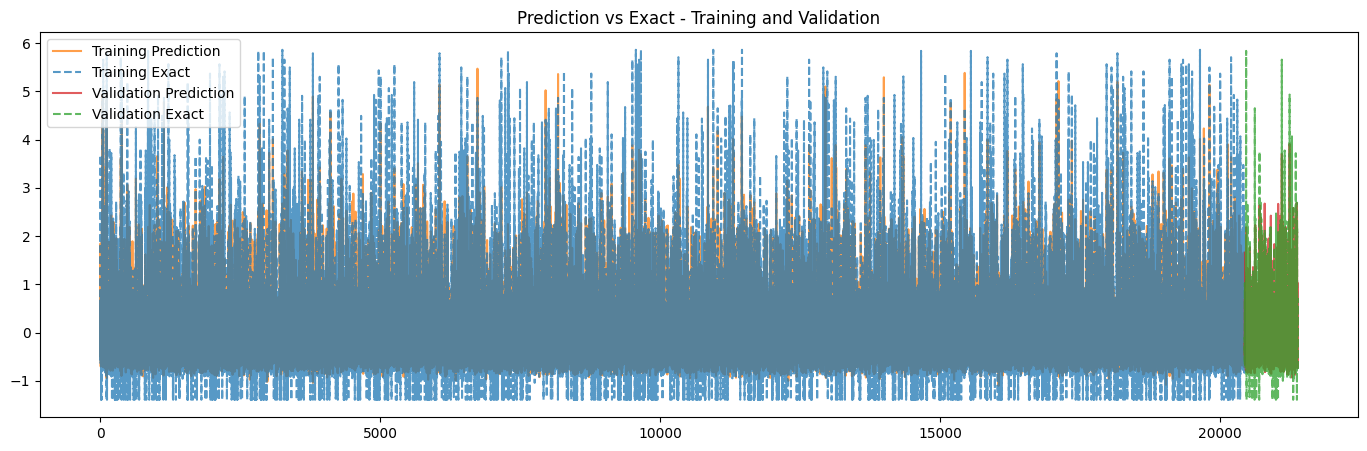

In [201]:
fig, ax, results = show_model_results(train_pred, val_pred, 'LSTM', y_train_lstm, y_val_lstm);
model_results.append(results)

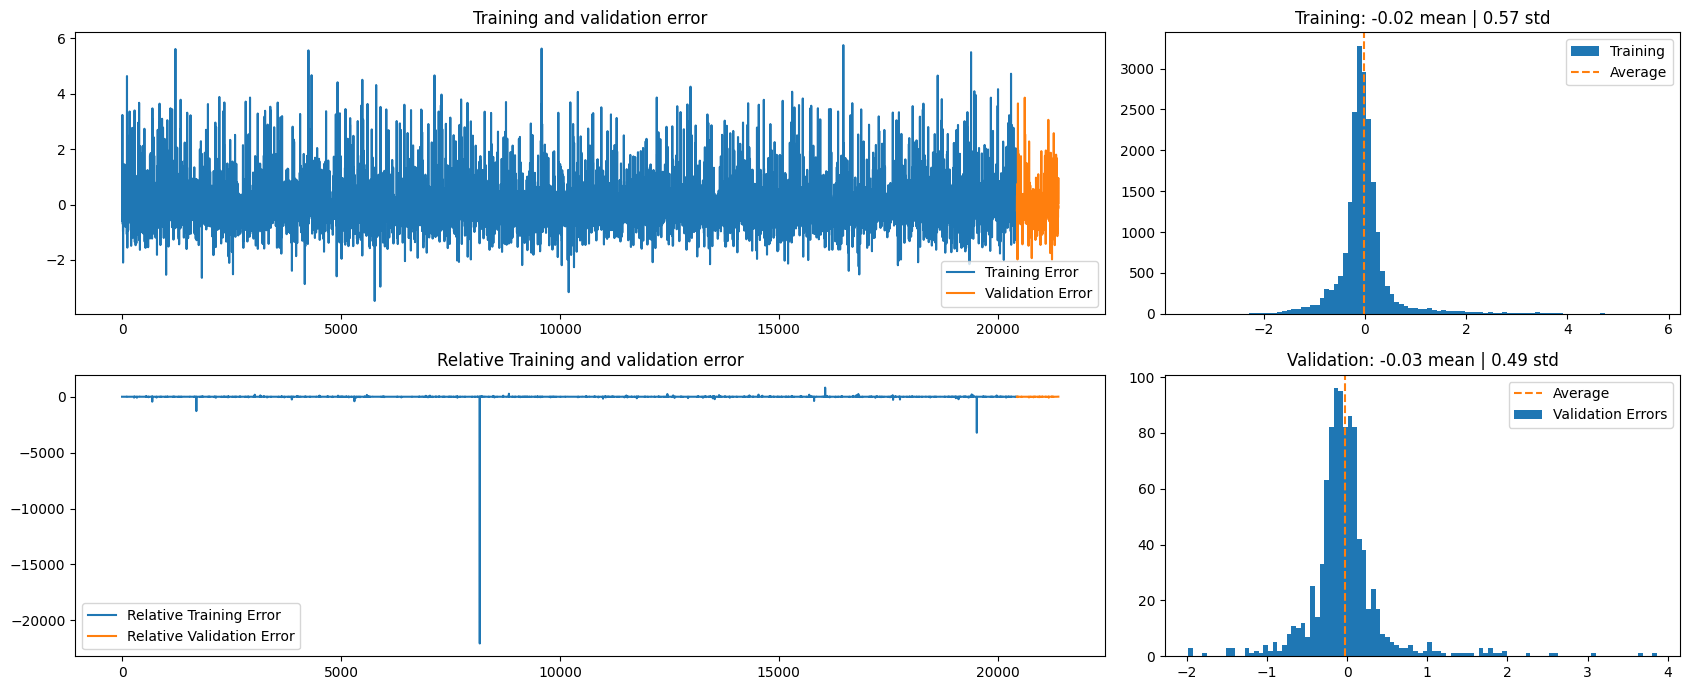

In [202]:
fig, ax = analyze_residuals(train_pred, val_pred, y_train_lstm, y_val_lstm)

## Feed Forward Neural Network with Multiple time steps

The first neural network was a simple feed forward neural network that takes one timestamp of each variable at the input. This network worked surprisingly well. The second network was an LSTM network which took 12 timestamps of each variable at the input. This network was more prone to overfitting, and was also not easily trainable.

The following model is a feed forward neural network which takes 12 timestamps at the input. 

In [203]:
def multi_ts_fw_net(n_inp_steps):
    inp = tf.keras.Input(shape=(n_inp_steps, train_features.shape[1]))
    conv = layers.Conv1D(16, 3, activation='relu')(inp)
    dense = tf.keras.layers.Dense(8, activation='relu')(conv)
    dense = tf.keras.layers.Dense(4, activation='relu')(dense)
    reshape = layers.Reshape((-1,))(dense)
    out = tf.keras.layers.Dense(1)(reshape)
    
    model = tf.keras.Model(inputs=inp, outputs=out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss=tf.keras.losses.mean_squared_error,
                metrics=['mse', 'mae'])
    return model

In [204]:
fw_multi_ts_model = multi_ts_fw_net(time_window_size)
fw_multi_ts_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 24, 25)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 22, 16)            1216      
                                                                 
 dense_31 (Dense)            (None, 22, 8)             136       
                                                                 
 dense_32 (Dense)            (None, 22, 4)             36        
                                                                 
 reshape_2 (Reshape)         (None, 88)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 89        
                                                                 
Total params: 1477 (5.77 KB)
Trainable params: 1477 (5.77 K

In [205]:
fw_multi_ts_model.fit(training_set, 
                      validation_data=validation_set, 
                      epochs=n_epochs)

Epoch 1/15
320/320 [==============================] - 1s 3ms/step - loss: 0.8878 - mse: 0.8878 - mae: 0.6335 - val_loss: 0.4582 - val_mse: 0.4582 - val_mae: 0.4221
Epoch 2/15
320/320 [==============================] - 1s 3ms/step - loss: 0.5822 - mse: 0.5822 - mae: 0.4556 - val_loss: 0.3620 - val_mse: 0.3620 - val_mae: 0.3712
Epoch 3/15
320/320 [==============================] - 1s 2ms/step - loss: 0.5247 - mse: 0.5247 - mae: 0.4323 - val_loss: 0.3610 - val_mse: 0.3610 - val_mae: 0.3914
Epoch 4/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4834 - mse: 0.4834 - mae: 0.4089 - val_loss: 0.3504 - val_mse: 0.3504 - val_mae: 0.3961
Epoch 5/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4584 - mse: 0.4584 - mae: 0.3989 - val_loss: 0.3230 - val_mse: 0.3230 - val_mae: 0.3431
Epoch 6/15
320/320 [==============================] - 1s 2ms/step - loss: 0.4428 - mse: 0.4428 - mae: 0.3936 - val_loss: 0.3144 - val_mse: 0.3144 - val_mae: 0.3352
Epoch 7/15
320/3

In [206]:
train_pred = unnormalize_target(fw_multi_ts_model.predict(training_set_no_shuf))
train_pred = train_pred[:, 0]
val_pred = unnormalize_target(fw_multi_ts_model.predict(validation_set))
val_pred = val_pred[:, 0]

15/15 [==============================] - 0s 2ms/step


,Training MAE,Training MSE,Validation MAE,Validation MSE
Multi Step FF,0.340151,0.332179,0.325692,0.28115


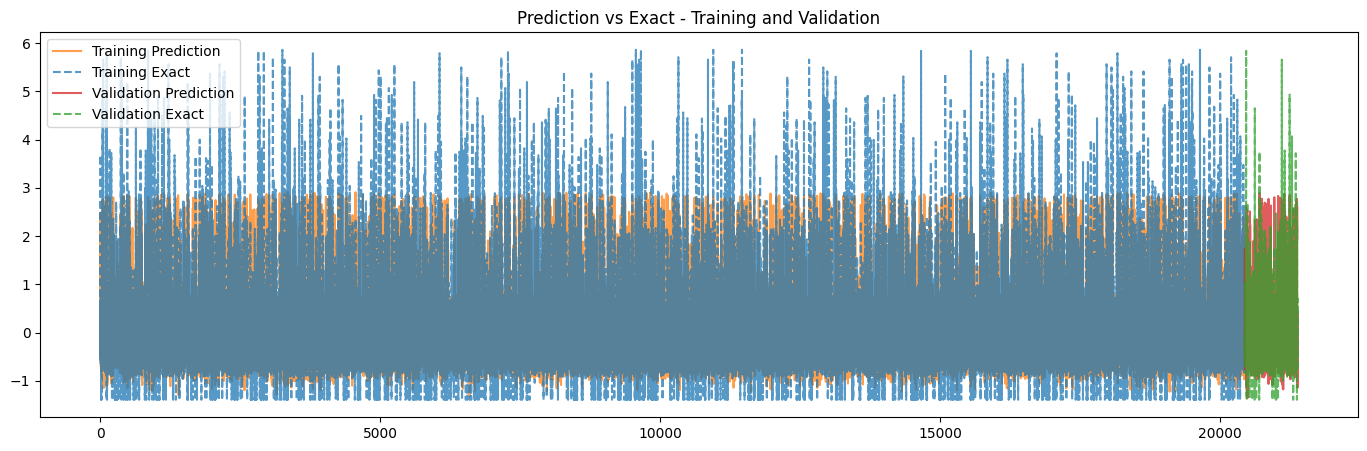

In [207]:
fig, ax, result = show_model_results(train_pred, val_pred, 'Multi Step FF', y_train_lstm, y_val_lstm);
model_results.append(result)

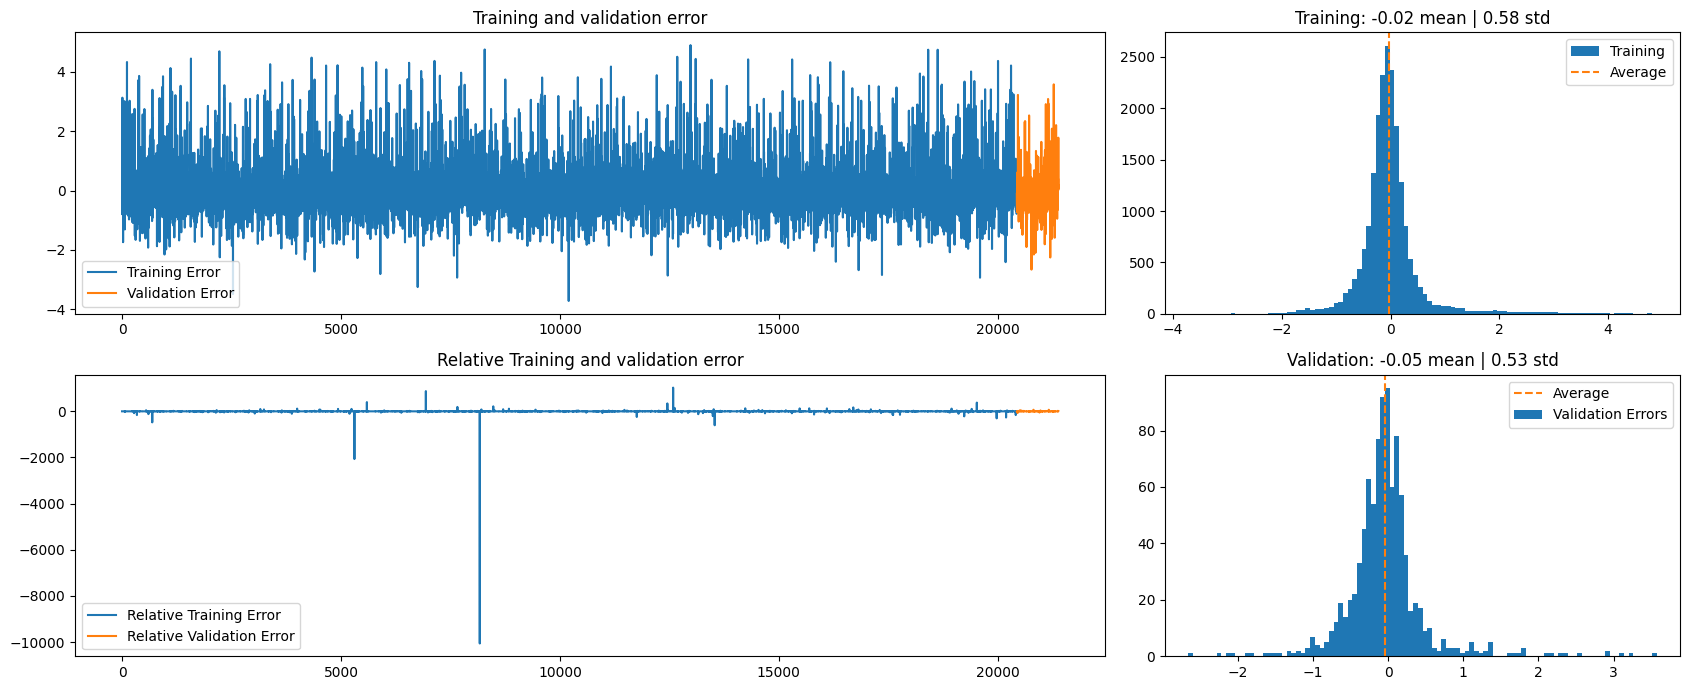

In [208]:
fig, ax = analyze_residuals(train_pred, val_pred, y_train_lstm, y_val_lstm)

# Summary

We now summarize the results. The following code block concatenates all model results into one table.

In [209]:
results = pd.concat(model_results)
results = results.loc[~results.index.duplicated()]
styled_results = results.style.background_gradient(cmap='Blues', axis=None, subset=['Training MAE',])
styled_results = styled_results.background_gradient(cmap='Greens', axis=None, subset=['Training MSE',])
styled_results = styled_results.background_gradient(cmap='Blues', axis=None, subset=['Validation MAE',])
styled_results = styled_results.background_gradient(cmap='Greens', axis=None, subset=['Validation MSE',])
styled_results

,Training MAE,Training MSE,Validation MAE,Validation MSE
Baseline Model,0.435285,0.968534,0.381549,0.757391
Linear Model,0.457585,0.632699,0.412680,0.457542
Gradient Boosting Model,0.020907,0.001167,0.057374,0.021928
Feed Forward NN,0.280616,0.517655,0.236435,0.330016
LSTM,0.319959,0.320008,0.290437,0.241225
Multi Step FF,0.340151,0.332179,0.325692,0.281150


## Other Ideas to Try
* Variable Selection
* Possible input data transformations, e.g. log-transformation
* Normalization Techniques, e.g. adding BatchNormalization layers into the neural networks
* Different cost functions, e.g. mean absolute error
* Searching larger hyperparameter grids for gradient boosting regressor
* Training for more epochs in neural networks
* Defining callbacks for Neural Network training: Variable learning rate, early stopping
* Combining different models based on e.g. Process information, observed clusters in the data analysis, etc.